### This is my final project at zero to gans, In this project I will try to classify masked and non masked images and my task is to get 85%+ accuracy(inshallah) on validation data using VGG19  

In [34]:
project_name='finalproject.ipynb'

In [2]:
!pip install jovian
import jovian

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6479 sha256=2d0bd011e5a7701f686c3ec1317ed69258349a9d5894c18c058c0bfd57ad028c
  Stored in directory: /root/.cache/pip/wheels/05/d7/b4/4795d29c6decfffbf64c63e58b6c8b8bbfd4751488617dcd7a
Successfully built uuid


<IPython.core.display.Javascript object>

In [3]:
!nvidia-smi

Fri Oct 14 12:43:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro M4000        Off  | 00000000:00:05.0 Off |                  N/A |
| 46%   25C    P8    12W / 120W |      0MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading necessary libraries

In [4]:
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import Compose
import torchvision.transforms as ttf
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# Hyperparameter

In [5]:
BATCH_SIZE = 10*2

epochs = 10

learningLR = 0.005
weight_decays = 5e-4
grad_clip = 0.3




# Loading Datasets and applying transforms



In [6]:
# transforming training dataset 
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

train_tranforms = Compose([ttf.Resize([128,128]),
                           ttf.RandomCrop(64),
                           ttf.RandomVerticalFlip(p=0.5),
                           ttf.AugMix(),
                           ttf.CenterCrop(150),
                           ttf.ToTensor(),
                           ttf.Normalize(*stats,inplace=True)])

test_transforms = Compose([ttf.Resize([128,128]),
                          ttf.ToTensor(),
                           ttf.Normalize(*stats,inplace=True)])

dev_transforms = Compose([ttf.Resize([128,128]),
                           ttf.ToTensor()])
                           #,ttf.Normalize(*stats,inplace=True)])


#loading with tranformations

path = '/notebooks/data/face-mask/raw/Face Mask Dataset/'

train_ds = ImageFolder(f'{path}Train',train_tranforms)
validation_ds = ImageFolder(f'{path}Validation',dev_transforms)
test_ds = ImageFolder(f'{path}Test',test_transforms)


train_loader = DataLoader(train_ds,BATCH_SIZE, shuffle=True,pin_memory=True, num_workers=2)
val_loader = DataLoader(validation_ds,BATCH_SIZE*2,pin_memory=True, num_workers=2)
test_loader = DataLoader(test_ds,BATCH_SIZE,pin_memory=True, num_workers=2)

classes = train_ds.classes

print("classes: ",classes)
print("length of train loader: ",len(train_loader))
print("length of val loader: ",len(val_loader))
print("length of test loader: ",len(test_loader))

classes:  ['WithMask', 'WithoutMask']
length of train loader:  500
length of val loader:  20
length of test loader:  50


# Retriving single batch of data

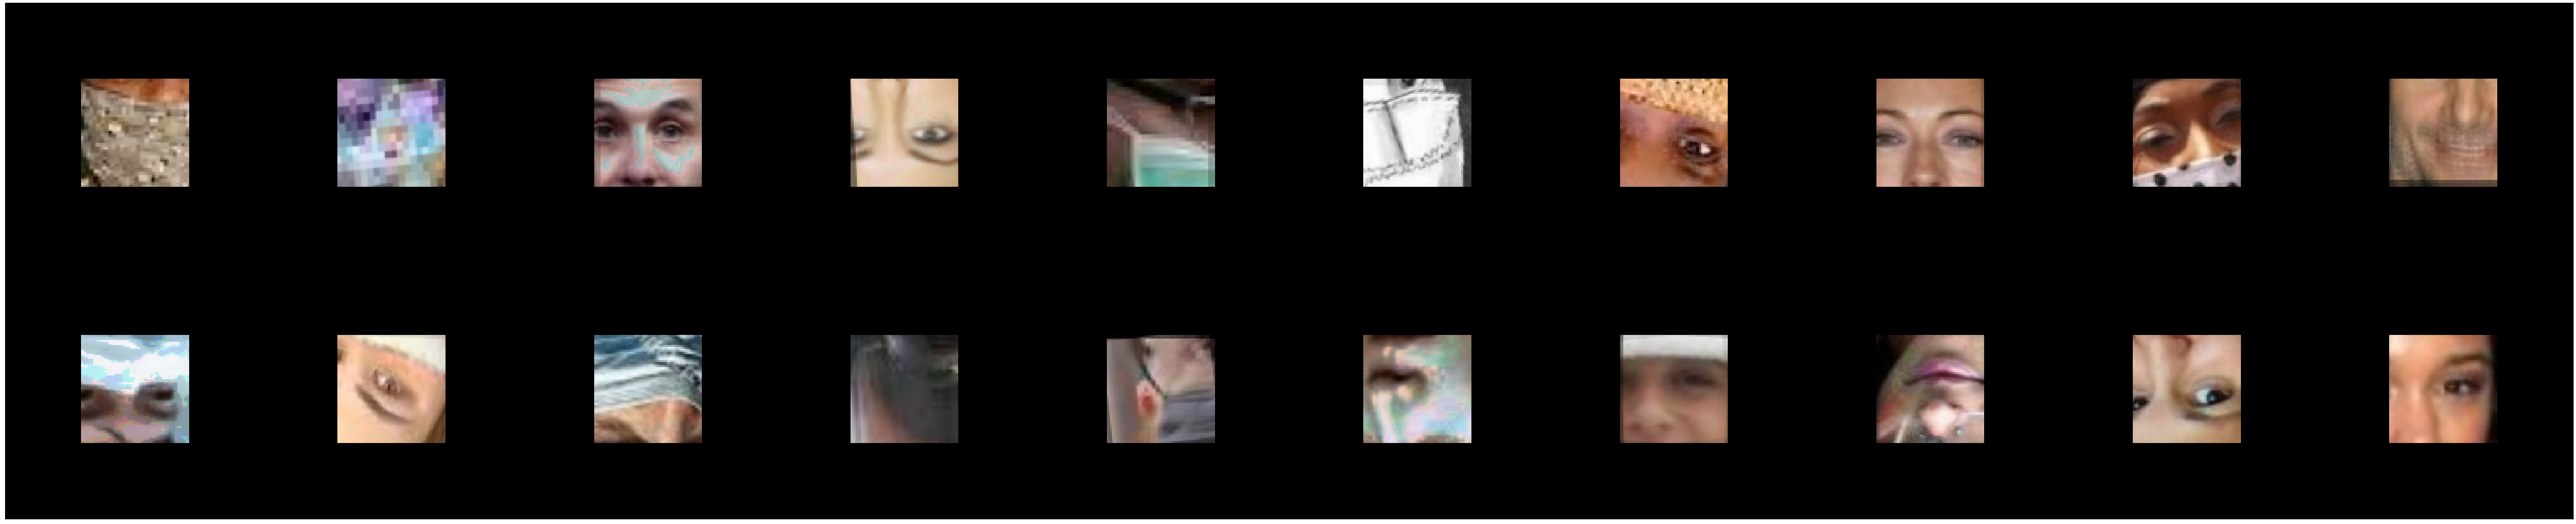

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(100, 100))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images, nrow=10).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

In [9]:
# count images per class

def count_data(loader):
    classes = loader.classes
    dict = {}

    for i in range(len(classes)):
        dict[loader.classes[i]] = 0
        
    for im,label in loader:
        dict[loader.classes[label]] += 1
    return dict
     
    

print("validation samples: ",count_data(validation_ds))
print("train samples: ",count_data(train_ds))
print("test samples: ",count_data(test_ds))

validation samples:  {'WithMask': 400, 'WithoutMask': 400}
train samples:  {'WithMask': 5000, 'WithoutMask': 5000}
test samples:  {'WithMask': 483, 'WithoutMask': 509}


In [10]:
# moving data to gpu
def default():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device


    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)


    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = default()
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

dataloaders = {  
    'train': train_dl,
    'validation': valid_dl
}


image_datasets = {
    'train': train_ds,
    'validation': validation_ds
}

In [11]:
from torchvision import models

model = models.vgg19(pretrained=True).to(device) 

# model = to_device(model, device)

# Freeze training for all layers
for param in model.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features).to(device) # Replace the model classifier


def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)


model.apply(init_normal)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Defining Training function

In [12]:
# for one cycle
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model,learningLR,weight_decays,num_epochs=epochs, grad_clip=grad_clip):
    

  train_loss,train_accu = [],[]
  val_loss,val_accu = [],[]
  epoch_n = []
    
  # cost functions
  criterion = nn.CrossEntropyLoss()
  # criterion = nn.NLLLoss()


  optimizer = torch.optim.SGD(model.parameters(),lr=learningLR,weight_decay=weight_decays,momentum= 0.9)
  
  #adam optimizer
  # optimizer = torch.optim.Adam(model.fc.parameters(),lr=learningLR,weight_decay=weight_decays)

  #One cycle LR algorithm
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learningLR, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))
  
  for epoch in range(num_epochs):

    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 50)
      
    lrs = []
  
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':

                loss.backward()                
                if grad_clip: 
                  nn.utils.clip_grad_value_(model.parameters(), grad_clip)

                optimizer.step()
                optimizer.zero_grad()
                
                #stepping schedualar 
                lrs.append(get_lr(optimizer))
                sched.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])
        
        
        if phase =="train":
            train_loss.append(epoch_loss)
            train_accu.append(epoch_acc)
            epoch_n.append(epoch)
            
        if phase =="validation":
            val_loss.append(epoch_loss)
            val_accu.append(epoch_acc)

        print("last learning rate: {:.3}".format(lrs[-1]))
        print('{} loss: {:.2f}%, acc: {:.2f}%\n'.format(phase,
                                                  epoch_loss*100,
                                                  epoch_acc*100))
  return [epoch,train_loss,val_loss,train_accu,val_accu,lrs]

# Actual Training 

In [13]:
%%time
hist = train_model(model,learningLR,weight_decays,num_epochs=epochs,grad_clip=grad_clip)


Epoch 1/10
--------------------------------------------------
last learning rate: 0.0014
train loss: 20.49%, acc: 91.55%

last learning rate: 0.0014
validation loss: 4.00%, acc: 99.00%


Epoch 2/10
--------------------------------------------------
last learning rate: 0.0038
train loss: 12.99%, acc: 95.41%

last learning rate: 0.0038
validation loss: 7.19%, acc: 97.00%


Epoch 3/10
--------------------------------------------------
last learning rate: 0.005
train loss: 10.32%, acc: 96.47%

last learning rate: 0.005
validation loss: 2.37%, acc: 99.62%


Epoch 4/10
--------------------------------------------------
last learning rate: 0.00475
train loss: 9.06%, acc: 96.77%

last learning rate: 0.00475
validation loss: 3.73%, acc: 98.88%


Epoch 5/10
--------------------------------------------------
last learning rate: 0.00406
train loss: 7.57%, acc: 97.49%

last learning rate: 0.00406
validation loss: 6.45%, acc: 98.88%


Epoch 6/10
--------------------------------------------------
la

# Checking accuracy on test dataset {on cpu mode coz my machine does not have gpu and I trained my model in GPU}

In [14]:
model = to_device(model, "cpu")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(batch,model) for batch in val_loader]
    return validation_epoch_end(outputs)

def validation_step(batch,model):
    images, labels = batch 
    out = model(images)                   # Generate predictions
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_acc': acc}

def validation_epoch_end(outputs):
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  
        return {'val_acc': epoch_acc.item()}

his = evaluate(model,test_loader)
print(f"Accuracy on test set is {int(his['val_acc']*100)}%")

Accuracy on test set is 99%


# Plotting Losses

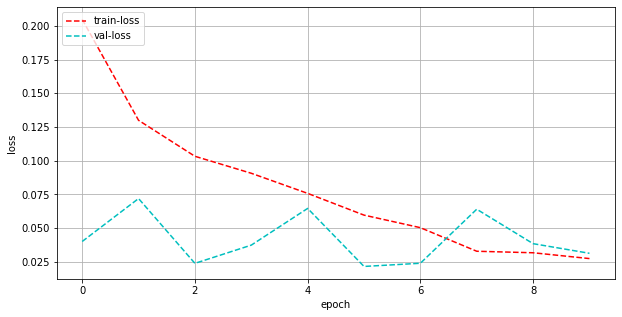

In [15]:
#[epoch,train_loss,val_loss,train_accu,val_accu,lr]
plt.rcParams["figure.figsize"] = (10,5)
epoch = [x for x in range(hist[0]+1)]

#loss chart
plt.plot(epoch,hist[1],"--r", label="train-loss")
plt.plot(epoch,hist[2], "--c" ,label="val-loss")

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid(True)
plt.rc('axes', axisbelow=True)

plt.legend(loc="upper left")
plt.show()

# plotting accuracies 

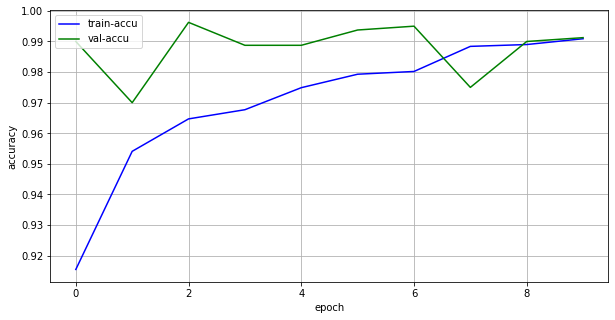

In [16]:
#accuracy chart

plt.plot(epoch,torch.tensor(hist[3]).cpu(),"-b", label="train-accu")
plt.plot(epoch,torch.tensor(hist[4]).cpu(), "-g" ,label="val-accu")

plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.grid(True)
plt.rc('axes', axisbelow=True)

plt.legend(loc="upper left")
plt.show()

# Plotting change of losses w.r.t accuracies

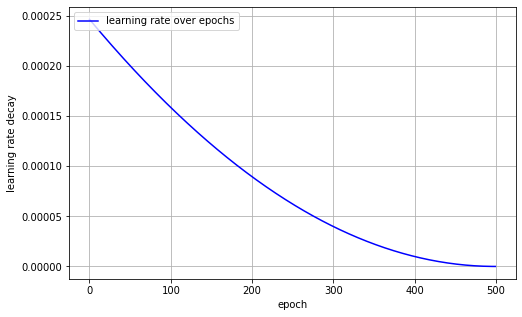

In [17]:
plt.rcParams["figure.figsize"] = (8,5)

epoch = [x for x in range(len(hist[5]))]
plt.plot(epoch,torch.tensor(hist[5]).cpu(),"-b", label="learning rate over epochs")

plt.legend(loc="upper left")

plt.xlabel("epoch")
plt.ylabel("learning rate decay")

plt.grid(True)
plt.rc('axes', axisbelow=True)

plt.show()

In [15]:
torch.save(model, "full-vgg19-version,99%-accuracy.pth")

# Loading pytorch model

In [45]:
import torch

model = torch.load('/notebooks/data/Final project/full-vgg16,99%-accuracy.pth')
model.state_dict()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
def pred_image(image,model):
    image = image.unsqueeze(0)
    out = model(image)
    _, pred = torch.max(out, dim=1)
    print(pred.item())
    return pred.item()

correct label is:  WithMask
0
predicted label:  WithMask


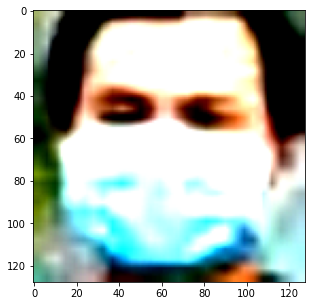

In [19]:
im , lb = test_ds[4]

plt.imshow(im.permute(1, 2, 0).clip(0,1))

print("correct label is: ",classes[lb])
print("predicted label: ", classes[pred_image(im,model)])

In [68]:
im.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

# Conclusion:
## After traning model for some epochs I got 90% accuracy + 99% accuracy on test dataset and I did inference with this model and it can detect face mask and no face mask with 95% accuracy which is a sucess for me after completing zero to gans course.
## To perform inference on this model i use below code:

In [1]:
import cv2
import torch
from torchvision import transforms
from torch.nn import functional as F
import pyshine as ps

model = torch.load('full-vgg19-version,99%-accuracy.pth')
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
classNames = ['WithMask', 'WithoutMask']

def cameraPredict():
    #get video capture object
    capture = cv2.VideoCapture(0)
    while(True):
        ret, frame = capture.read()

        # transforming images 
        frameInput = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frameInput = cv2.resize(frame, (128, 128))
        frameInput=transforms.ToTensor()(frameInput)

        #passing images to model
        l = model(transforms.Normalize(*stats,inplace=True)(frameInput).unsqueeze(0))

        #calculating probabilities
        _,pred = torch.max(l,dim=1)
        probs = F.softmax(l, dim=1)
        rltd_probs =probs[0][pred.item()]

        #predicted label
        
        predLabel = classNames[pred]

        frame =  ps.putBText(frame,f'{str(predLabel)}: {int(rltd_probs*100)}%',text_offset_x=30,text_offset_y=70,
                                        vspace=10,hspace=10, font_scale=1,background_RGB=(0,250,250),
                                        text_RGB=(160,32,240))
        
        #get keyboard input
        k = cv2.waitKey(1)
        if k == ord('q'):
            break
            
        cv2.imshow('frame',frame)
    capture.release()
    cv2.destroyAllWindows()

cameraPredict()



KeyboardInterrupt



In [28]:
jovian.log_metrics(test_acc=his['val_acc'])

[jovian] Metrics logged.


In [31]:
jovian.commit(filename=)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"


In [32]:

jovian.log_hyperparams(arch='vgg19', 
                       epochs=epochs, 
                       lr=learningLR, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decays, 
                       grad_clip=grad_clip,
                       opt="SGD")

jovian.commit(project=project_name, environment="paper-space", outputs=['full-vgg19-version,99%-accuracy.pth'])

[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Error: Failed to read the Jupyter notebook. Please re-run this cell to try again. If the issue persists, provide the "filename" argument to "jovian.commit" e.g. "jovian.commit(filename='my-notebook.ipynb')"
